# Import modules

In [2]:
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import re
import statistics



# Optional: Strip HTML

In [10]:
# cols = ['ClapCount_Card', 'ClapCount_Story', 'Company', 'CompanyURL', 'PostID',
#        'PublishedDate', 'ReadingTime', 'ResponseNum_Card', 'ResponseNum_Story',
#        'StoryHTML', 'StoryIndex', 'StoryTitle', 'StoryURL', 'StoryURL_Story',
#        'Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5', 'TagSource', 'User', 'UserURL',
#        'VoterCount', 'isPaywall']


cols = ['ClapCount_Card', 'ClapCount_Story', 'Company', 'CompanyURL', 'PostID',
       'PublishedDate', 'ReadingTime', 'ResponseNum_Card', 'ResponseNum_Story',
       'StoryIndex', 'StoryTitle', 'StoryURL', 'StoryURL_Story',
       'Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5', 'TagSource', 'User', 'UserURL',
       'VoterCount', 'isPaywall']
import pandas as pd
reader = pd.read_csv('df_story.csv', chunksize=20000)
for chunk in reader:
    chunk.to_csv('df_noHTML.csv', index=False, header=False, mode='a')

    result = chunk
    result['StoryHTML'] = ''

    result.to_csv('df_noHTML.csv', index=False, header=False, mode='a')



In [ ]:
df_noHTML = pd.read_csv("df_noHTML.csv", names=cols)
display(HTML(df_noHTML.head(5).to_html()))

# Import data and filter N/A stories

NameError: name 'df' is not defined

In [211]:
df = pd.read_csv("data/df_story_chunk1.csv", nrows=100)
df.head()
df = df[-df['PostID'].isnull()]
df = df[-df['ReadingTime'].isnull()]

print(len(df))


98


# Check NA

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: PostID, Length: 10000, dtype: bool

# Extract features from HTML

In [97]:
# display(HTML(df.tail().to_html()))

In [3]:

# Text from raw HTML
def extract_features_from_html(data):
    if pd.notnull(data['StoryHTML']):
               
        # Using beautifulsoup        
        soup = BeautifulSoup(data['StoryHTML'])
        
        
        # Extract num. images
        img_count = int(len(soup.find_all("img")))

        
        # Header information (author / title) is stored in <div> tag with no classname attribute
        # It is also the second section tag
        featured_image = False
        
        header = soup.find_all("section") # Header is the second section
        if len(header)>=2:
            if header[1].find_all("img", {"role":"presentation"}):
                featured_image = True

        # First <div> tag is the article itself, remove every other <div> afterwards
        headerDivs = soup.find_all("div", {'class':None})
        if (headerDivs):  
            for div in headerDivs[1:]:
                div.decompose()
        
        # Extract Text
        text = soup.text
        
        # Extract num. words
        word_count = int(len(soup.text.split()))
        
        # Extract code
        # There are four ways that authors display code in a Medium article, the first two are retrievable.
        # 1) Codeblock: Use ``` ``` which is converted into <pre> tag. Available in data.
        # 2) Inline: <code> tag. Available in data.
        # 3) Import a Gist file. N/A in data since Gists are embedded content which are not captured by Scrapy and would require a deeper request level.
        # 4) Show it as an image. N/A in data since there is no distinguishing tag for "code" images and normal images.
        
        
        # Extract num. code blocks that use the Medium ``` format (have <pre> tag)
        codeblocks_default = soup.find_all("pre")

        codeblock_raw = [code.text for code in codeblocks_default]
        
        codeblock_num = len(codeblocks_default)
        
        # Get a list of the number of lines of code of each code block
        # Every code block has number of <br> + 1 lines
            # <pre>
            # ....
            # <br>
            # ....
            # </pre>        
        # Then compute basic statistics
        
        codeblock_lengths = [len(codeblock.find_all("br"))+len(codeblock.find_all("span")) for codeblock in codeblocks_default]
        if len(codeblock_lengths) > 0:
            codeblock_length_sum = sum(codeblock_lengths)
            codeblock_length_median = statistics.median(codeblock_lengths)
            codeblock_length_mean = statistics.mean(codeblock_lengths)
            codeblock_length_min = min(codeblock_lengths)
            codeblock_length_max = max(codeblock_lengths)
        else:
            codeblock_length_sum = 0
            codeblock_length_median = 0
            codeblock_length_mean = 0
            codeblock_length_min = 0
            codeblock_length_max = 0
            
            
        # Extract number of <code> tags (inline code)
        code_inline = soup.find_all("code")
        code_inline_raw = [code.text for code in code_inline]
        code_inline_num = len(code_inline)

            
        # Extract num. Gist code blocks
        # Gist code blocks have form <figure class="ab cd ef ... >"
        # <figure> is also used to wrap images in article have form: 
            # <figure class = "ab cd ef ... paragraph-image", so we exclude those figure elements

            
#         gists = soup.find_all("figure")
#         if len(gists)>0:
#             code_gist_count = len([x for x in gists if x.attrs.get("class") and "paragraph-image" not in x.attrs.get("class")])
#         else:
#             code_gist_count = 0
            
                
        # Extract a list of total links and their URLs
        # We need to filter out Medium's internal links (share post, author profile, etc)
        # These links contain the PostID, so we only collect <a> tags with href not containing PostID
        links_all = soup.find_all("a")
        link_urls = [link.attrs.get('href') for link in links_all if str(data['PostID']) not in link.attrs.get('href')]
        

        # Extract total number of links
        link_count = int(len(link_urls))
        
        # Extract number of highlights
        highlights = soup.find_all("mark")
        highlight_count = int(len(highlights))

        # Extract highlight text
        highlights_text = [hlt.text for hlt in highlights]

        # Extract image count
        # A genuine image does not have alt (used for user logo), so we use this fact to verify image elements
        # Get src and find number of unique URLs to find number of images
#         imgli = soup.find_all("img")
#         newLi = [re.search("\*.+(?![^\.])", img['src']).group(0).split(".", 1)[0] for img in imgli if (img.has_attr('src') and re.search("\*.+(?![^\.])", img['src']) is not None)]
#         if len(newLi) == 0:
#             img_count = len(set([img.attrs['src'] for img in imgli if img.has_attr('src')]))
#         else:
#             img_count = len(set(newLi))-1
    else:
        text = np.NaN
        word_count = np.NaN
        code_count = np.NaN
        img_count = np.NaN
        featured_image = np.NaN
        link_count = np.NaN
        link_urls = np.NaN
        highlights_text = np.NaN
        highlight_count = np.NaN
        code_inline_raw = np.NaN
        code_inline_num = np.NaN
        codeblock_raw = np.NaN
        codeblock_num = np.NaN
        codeblock_lengths = np.NaN
        codeblock_length_sum = np.NaN
        codeblock_length_median = np.NaN
        codeblock_length_mean = np.NaN
        codeblock_length_min = np.NaN
        codeblock_length_max = np.NaN
        
    return text, word_count, featured_image, code_inline_raw, code_inline_num, codeblock_raw, codeblock_num, codeblock_lengths, codeblock_length_sum, codeblock_length_median, codeblock_length_mean, codeblock_length_min, codeblock_length_max, img_count, link_urls, link_count, highlights_text, highlight_count
    
# test = df
# test[['Text', 'WordNum', 'HasFeaturedImage','CodeInlineRaw', 'CodeInlineNum', 'CodeBlockRaw', 'CodeBlockNum', "CodeBlockLengthList", "CodeBlockLengthSum", "CodeBlockLengthMedian", "CodeBlockLengthMean", "CodeBlockLengthMin", "CodeBlockLengthMax", 'ImgNum', 'LinkURLList', 'LinkNum', 'HLightTextList', 'HlightNum']] = df.apply(extract_features_from_html, axis=1, result_type="expand")
# del test['StoryHTML']

In [214]:
# display(HTML(test.sample(1).to_html()))
# display(HTML(test[test['PostID'] == 'e12a11dc4a4f'].to_html()))
# display(HTML(test[test['HasFeaturedImage'] == False].to_html()))


# Generate feature extracted data

In [64]:


count = 0
header = True

numRows = 100000
chunkSize = 10000

processedRows = 0
for data in pd.read_csv('data/df_story_chunk1.csv',encoding = 'ISO-8859-1', nrows=numRows, chunksize  = chunkSize, low_memory=False):
    count += 1                          # counting the number of chunks
    lastlen = len(data)                 # finding the length of last chunk

    # Filter NaN PostID
    data = data[-data['PostID'].isnull()]      
    
    # Filter NaN ResponseTime
    data = data[-data['ReadingTime'].isnull()] 

    
    # Filter stories posted after April 2020
    data['PublishedDate'] = pd.to_datetime(data['PublishedDate']).dt.date
    data = data[data['PublishedDate'] < pd.to_datetime("2020-04-01")]

    
    # Convert responsetime "X min read" to X as int
    data['ReadingTime'] = data['ReadingTime'].str.extract('(\d+)', expand=False).astype(int) 
    
    # Get number of tags used
    data['TagSum'] = data[['Tag1','Tag2','Tag3','Tag4', 'Tag5']].notnull().sum(axis=1)

    # Extract features  from HTML
    data[['Text', 'WordNum', 'HasFeaturedImage','CodeInlineRaw', 'CodeInlineNum', 'CodeBlockRaw', 'CodeBlockNum', "CodeBlockLengthList", "CodeBlockLengthSum", "CodeBlockLengthMedian", "CodeBlockLengthMean", "CodeBlockLengthMin", "CodeBlockLengthMax", 'ImgNum', 'LinkURLList', 'LinkNum', 'HLightTextList', 'HlightNum']] = data.apply(extract_features_from_html, axis=1, result_type="expand")
    
    # Delete raw html
    del data['StoryHTML']
    
    processedRows += len(data)
    
    data.to_csv("data/df_story_features.csv", header=header, mode="a")
    header = False
datalength = (count*chunkSize + lastlen - chunkSize) # length of total file
print(datalength, "rows read", processedRows, "rows clean")

100000 rows read 80038 rows clean


In [55]:
test = pd.read_csv("data/df_story_features.csv")
# display(HTML(test.head().to_html()))

display(test['PublishedDate'])

0       2020-02-04
1       2018-12-31
2       2018-12-31
3       2019-12-31
4       2016-12-30
           ...    
2220    2018-12-10
2221    2018-12-10
2222    2018-12-10
2223    2018-12-10
2224    2018-12-01
Name: PublishedDate, Length: 2225, dtype: object

In [269]:
test_html = df.iloc[547].StoryHTML
testsoup = BeautifulSoup(test_html, 'lxml')
print(testsoup.find_all("figure", {'class':re.compile("/.*[^image]$/")}))

[]


In [198]:
# display(HTML(df.head(5).to_html()))
pd.set_option('display.max_colwidth', -1)

print(df[df['CodeNum']>0].head(100)['StoryURL'].to_string())



545    https://medium.com/dataform/sending-data-from-bigquery-to-intercom-using-google-cloud-functions-c65f26906a4?source=tag_archive---------2-----------------------
546    https://medium.com/datadriveninvestor/java-enums-what-a-special-type-276d27423a71?source=tag_archive---------0-----------------------                          


9.057077070026525


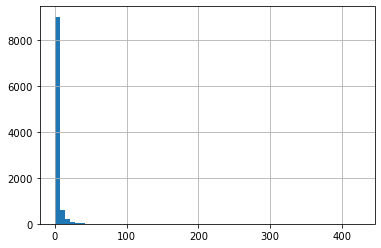

In [363]:
import matplotlib.pyplot as plt
print(df[df['CodeBlockLengthMean']>0]['CodeBlockLengthMean'].mean())
df['CodeBlockLengthMean'].hist(bins=60)
plt.show()